In [44]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors #type: ignore
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns

In [16]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

def make_tests(X, y):
    indices = np.arange(len(y))
    X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(X, y.ravel(),indices, train_size = 0.8, shuffle = True)
    return X_train, X_test, y_train, y_test, indices_train, indices_test
def model_score(model, X ,y):
    predicted = model.predict(X).reshape(-1, 1)
    blow_up_index = np.where(abs(predicted)>100)[0]
    normal = np.arange(len(y))[~np.isin(np.arange(len(y)), blow_up_index)]
    y = y[normal]
    predicted = predicted[normal]
    #print(np.max(np.abs(predicted - y)))
    r2 = r2_score(predicted, y)
    mse = mean_squared_error(predicted, y)
    return r2, mse
def cross_validate_model(X, y, model, n_splits=10):
    scores = []
    for i in range(n_splits):
        X_train, X_test, y_train, y_test, indices_train, indices_test = make_tests(X, y)
        trained_model = model.fit(X_train, y_train)
        scores.append(model_score(trained_model, X_test, y_test))
    return np.array(scores)

def summarize_scores(scores):
    mse_mean = np.mean(scores[:, 1])
    r2_mean = np.mean(scores[:, 0])
    mse_std = np.std(scores[:, 1]) / np.sqrt(len(scores))
    r2_std = np.std(scores[:, 0]) / np.sqrt(len(scores))
    return mse_mean, r2_mean, mse_std, r2_std

def getKeys(corr_thres):
    numeric_df = df_with_200_descriptors.dropna()

    corr_mat = numeric_df.corr().abs()
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > corr_thres)]

    # Drop highly correlated features
    final_df = numeric_df.drop(columns=to_drop)
    return final_df.keys()


In [3]:
# freesolv
freesoldf = pd.read_csv("../DataSets/freesolv.csv")
freesoldf = freesoldf.drop("Unnamed: 0", axis=1)
# MNSol
mnsoldf = pd.read_csv("../DataSets/mnsol.csv", sep = ";")
mnsoldf_water = mnsoldf.loc[mnsoldf['Solvent'] == 'water']
mnsoldf = mnsoldf_water.reset_index().drop("index", axis = 1)
# CombiSolv-EXP
combisolv = pd.read_csv("../DataSets/CombiSolv-Exp-8780.csv", sep = ",")

## Combisolv dataset preparation and cleaning..
combisolv['SolventSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[0])
combisolv['SoluteSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[1])
combisolv['Solute'] = "solute"
combisolv['Solvent'] = "solvent"
combisolv.rename(columns = {'dgsolv':'DeltaGsolv'}, inplace = True)
combisolv.drop(columns=['ssid'], inplace = True)
combisolv = combisolv.loc[combisolv['SolventSMILES'] == "O"]
combisolv.reset_index().drop("index", axis = 1, inplace = True)
combisolv = combisolv[['Solute', 'Solvent', 'SoluteSMILES',
                        'SolventSMILES', 'DeltaGsolv']]

## Smiles to Mol conversion
freesoldf['mol'] = freesoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
mnsoldf['mol'] = mnsoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
combisolv['mol'] = combisolv['SoluteSMILES'].apply(Chem.MolFromSmiles)

[00:24:03] WARNING: not removing hydrogen atom without neighbors


In [4]:
full = pd.read_csv("../DataSets/Full_Free_Solv/full.csv", delimiter=";")
## Freesolv
#freesolv = pd.read_csv("../DataSets/Full_Free_Solv/full.csv")
full = full[["SoluteSMILES", "DeltaGsolv"]]
#freesolv['fp'] = freesolv['SoluteSMILES'].apply(lambda x: MAP4.calculate(Chem.MolFromSmiles(x)))
Mol_descriptors,desc_names = RDkit_descriptors(full['SoluteSMILES'])

[00:24:17] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 95, in __init__
    self.score /= self.mol.GetNumHeavyAtoms()
ZeroDivisionError: division by zero
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
  File "/home/

In [5]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors = df_with_200_descriptors.loc[:, df_with_200_descriptors.std() != 0]
#df_with_200_descriptors

In [7]:
keys_95 = getKeys(0.95)
keys_85 = getKeys(0.85)
keys_75 = getKeys(0.75)
keys_65 = getKeys(0.65)
keys_55 = getKeys(0.55)

In [8]:
# freesolv
freesoldf = pd.read_csv("../DataSets/freesolv.csv")
freesoldf = freesoldf.drop("Unnamed: 0", axis=1)
# MNSol
mnsoldf = pd.read_csv("../DataSets/mnsol.csv", sep = ";")
mnsoldf_water = mnsoldf.loc[mnsoldf['Solvent'] == 'water']
mnsoldf = mnsoldf_water.reset_index().drop("index", axis = 1)
# CombiSolv-EXP
combisolv = pd.read_csv("../DataSets/CombiSolv-Exp-8780.csv", sep = ",")

## Combisolv dataset preparation and cleaning..
combisolv['SolventSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[0])
combisolv['SoluteSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[1])
combisolv['Solute'] = "solute"
combisolv['Solvent'] = "solvent"
combisolv.rename(columns = {'dgsolv':'DeltaGsolv'}, inplace = True)
combisolv.drop(columns=['ssid'], inplace = True)
combisolv = combisolv.loc[combisolv['SolventSMILES'] == "O"]
combisolv.reset_index().drop("index", axis = 1, inplace = True)
combisolv = combisolv[['Solute', 'Solvent', 'SoluteSMILES',
                        'SolventSMILES', 'DeltaGsolv']]

## Adding cannonical smiles for comparison..
combisolv['cannon_smiles'] = combisolv['SoluteSMILES'].apply(lambda x : Chem.CanonSmiles(x))
mnsoldf['cannon_smiles'] = mnsoldf['SoluteSMILES'].apply(lambda x : Chem.CanonSmiles(x))
freesoldf['cannon_smiles'] = freesoldf['SoluteSMILES'].apply(lambda x : Chem.CanonSmiles(x))


[00:24:57] WARNING: not removing hydrogen atom without neighbors


In [9]:
Mol_descriptors_mnsol,desc_names = RDkit_descriptors(mnsoldf['SoluteSMILES'])
Mol_descriptors_freesoldf,desc_names = RDkit_descriptors(freesoldf['SoluteSMILES'])
Mol_descriptors_combisoldf,desc_names = RDkit_descriptors(combisolv['SoluteSMILES'])

[00:25:03] WARNING: not removing hydrogen atom without neighbors
[00:25:04] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 95, in __init__
    self.score /= self.mol.GetNumHeavyAtoms()
ZeroDivisionError: division by zero
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    re

In [10]:
def get_uncorr_dfs(keys):
    mnsol_df = pd.DataFrame(Mol_descriptors_mnsol,columns=desc_names)
    mnsol_df = mnsol_df[keys]

    freesol_df = pd.DataFrame(Mol_descriptors_freesoldf,columns=desc_names)
    freesol_df = freesol_df[keys]

    combisol_df = pd.DataFrame(Mol_descriptors_combisoldf,columns=desc_names)
    combisol_df = combisol_df[keys]
    return mnsol_df, freesol_df, combisol_df

In [11]:
mnsol_df95, freesol_df95, combisol_df95 = get_uncorr_dfs(keys_95)
mnsol_df85, freesol_df85, combisol_df85 = get_uncorr_dfs(keys_85)
mnsol_df75, freesol_df75, combisol_df75 = get_uncorr_dfs(keys_75)
mnsol_df65, freesol_df65, combisol_df65 = get_uncorr_dfs(keys_65)
mnsol_df55, freesol_df55, combisol_df55 = get_uncorr_dfs(keys_55)

In [18]:
from xgboost import XGBRegressor

def train_xgb(df, target):
    model = XGBRegressor()
    return cross_validate_model(df.values, target.values, model)

# Data dictionary with percentages
solvent_data = {
    95: (mnsol_df95, freesol_df95, combisol_df95),
    85: (mnsol_df85, freesol_df85, combisol_df85),
    75: (mnsol_df75, freesol_df75, combisol_df75),
    65: (mnsol_df65, freesol_df65, combisol_df65),
    55: (mnsol_df55, freesol_df55, combisol_df55)
}

# Target values dictionary
targets = {
    "mnsol": mnsoldf['DeltaGsolv'],
    "fsol": freesoldf['DeltaGsolv'],
    "csol": combisolv['DeltaGsolv']
}

# Storing results
xgb_results = {}

for perc, (mnsol, fsol, csol) in solvent_data.items():
    xgb_results[f"xgb_{perc}_mnsol"] = train_xgb(mnsol, targets["mnsol"])
    xgb_results[f"xgb_{perc}_fsol"] = train_xgb(fsol, targets["fsol"])
    xgb_results[f"xgb_{perc}_csol"] = train_xgb(csol, targets["csol"])


In [1]:
#xgb_results

In [36]:
# Compute standard deviations dynamically
percentages = [55, 65, 75, 85, 95]
solvent_types = ["mnsol", "fsol", "csol"]

std_results_r2 = {
    solvent: [np.std(xgb_results[f"xgb_{perc}_{solvent}"][:, 0])/np.sqrt(10) for perc in percentages]
    for solvent in solvent_types
}

mean_results_r2 = {
    solvent: [np.mean(xgb_results[f"xgb_{perc}_{solvent}"][:, 0]) for perc in percentages]
    for solvent in solvent_types
}

std_results_mse = {
    solvent: [np.std(xgb_results[f"xgb_{perc}_{solvent}"][:, 1])/np.sqrt(10) for perc in percentages]
    for solvent in solvent_types
}

mean_results_mse = {
    solvent: [np.mean(xgb_results[f"xgb_{perc}_{solvent}"][:, 1]) for perc in percentages]
    for solvent in solvent_types
}

mnsol_stds_r2, fsol_stds_r2, csol_stds_r2 = std_results_r2["mnsol"], std_results_r2["fsol"], std_results_r2["csol"]
mnsol_means_r2, fsol_means_r2, csol_means_r2 = mean_results_r2["mnsol"], mean_results_r2["fsol"], mean_results_r2["csol"]

mnsol_stds_mse, fsol_stds_mse, csol_stds_mse = std_results_mse["mnsol"], std_results_mse["fsol"], std_results_mse["csol"]
mnsol_means_mse, fsol_means_mse, csol_means_mse = mean_results_mse["mnsol"], mean_results_mse["fsol"], mean_results_mse["csol"]

In [37]:
plt.style.use("/home/dm/Dibyendu/Projects/CVSampler/NoteBooks/style.txt")
plt.rcParams['font.family'] = "C059"

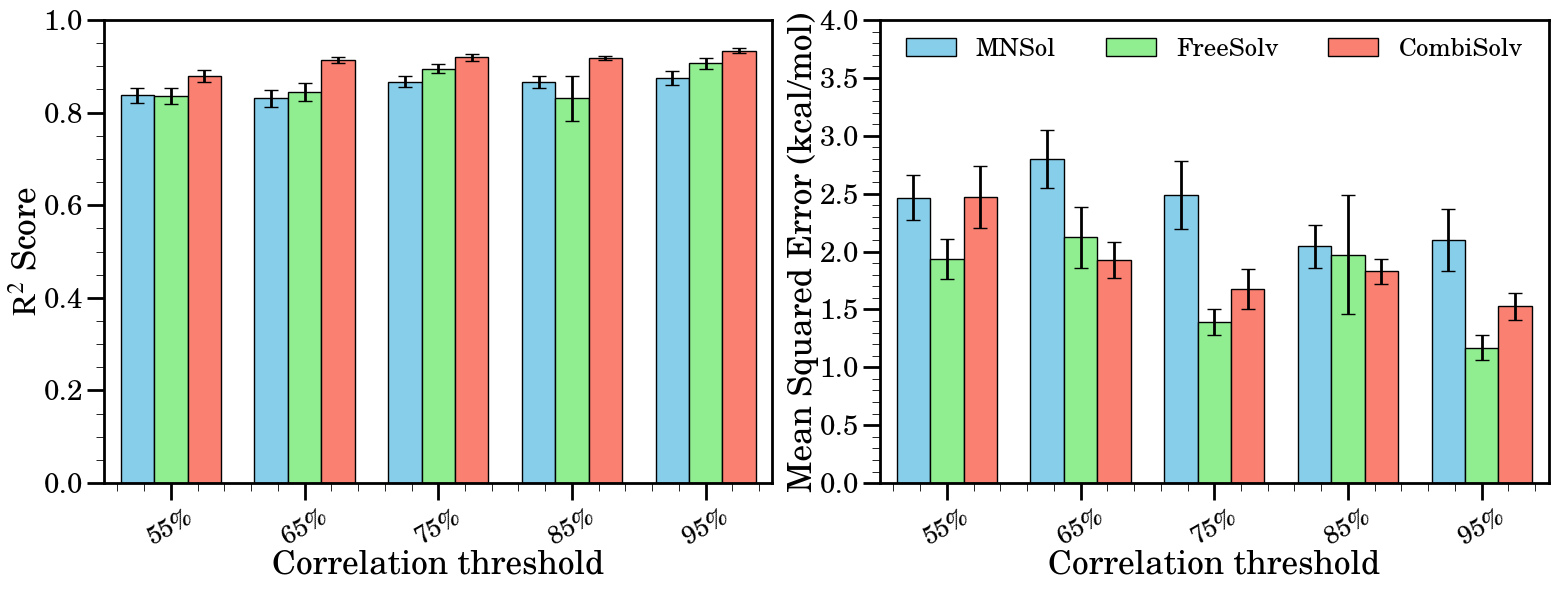

In [39]:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Data for the plot
representations = ['55%', '65%', '75%', '85%', "95%"]

# Create the bar plot
bar_width = 0.25
x = np.arange(len(representations))

bars1 = ax[0].bar(x - bar_width, mnsol_means_r2, bar_width, yerr=mnsol_stds_r2, capsize=5, label='MNSol', color='skyblue', edgecolor='black', lw = 1.)
bars2 = ax[0].bar(x, fsol_means_r2, bar_width, yerr=fsol_stds_r2, capsize=5, label='FreeSolv', color='lightgreen', edgecolor='black', lw = 1)
bars3 = ax[0].bar(x + bar_width, csol_means_r2, bar_width, yerr=csol_stds_r2, capsize=5, label='CombiSolv', color='salmon', edgecolor='black', lw = 1)

# Add labels and title
ax[0].set_xlabel('Correlation threshold', fontsize=24)
ax[0].set_ylabel(r'$\rm R^2$ Score', fontsize=24)

#ax.set_title('Comparison of Different Representations (Mean R2 Score with Std Error)', fontsize=16)
ax[0].set_xticks(x)
ax[0].set_xlim(-0.5, 4.5)
ax[0].set_ylim(0, 1.)
ax[0].set_xticklabels(representations, rotation=30, ha='center', fontsize=18)
#ax[0].legend(ncols = 3, fontsize = 18, loc = "upper center")

# Create the bar plot
bar_width = 0.25
x = np.arange(len(representations))

bars1 = ax[1].bar(x - bar_width, mnsol_means_mse, bar_width, yerr=mnsol_stds_mse, capsize=5, label='MNSol', color='skyblue', edgecolor='black', lw = 1.)
bars2 = ax[1].bar(x, fsol_means_mse, bar_width, yerr=fsol_stds_mse, capsize=5, label='FreeSolv', color='lightgreen', edgecolor='black', lw = 1)
bars3 = ax[1].bar(x + bar_width, csol_means_mse, bar_width, yerr=csol_stds_mse, capsize=5, label='CombiSolv', color='salmon', edgecolor='black', lw = 1)

# Add labels and title
ax[1].set_xlabel('Correlation threshold', fontsize=24)

ax[1].set_ylabel(r'Mean Squared Error (kcal/mol)', fontsize=24)
#ax.set_title('Comparison of Different Representations (Mean R2 Score with Std Error)', fontsize=16)
ax[1].set_xticks(x)
ax[1].set_xlim(-0.5, 4.5)
ax[1].set_ylim(0, 4.)
ax[1].set_xticklabels(representations, rotation=30, ha='center', fontsize=18)
ax[1].legend(ncols = 3, fontsize = 18, loc = "upper center")


fig.tight_layout()
#plt.savefig("Corr_Dependency_descr.png")

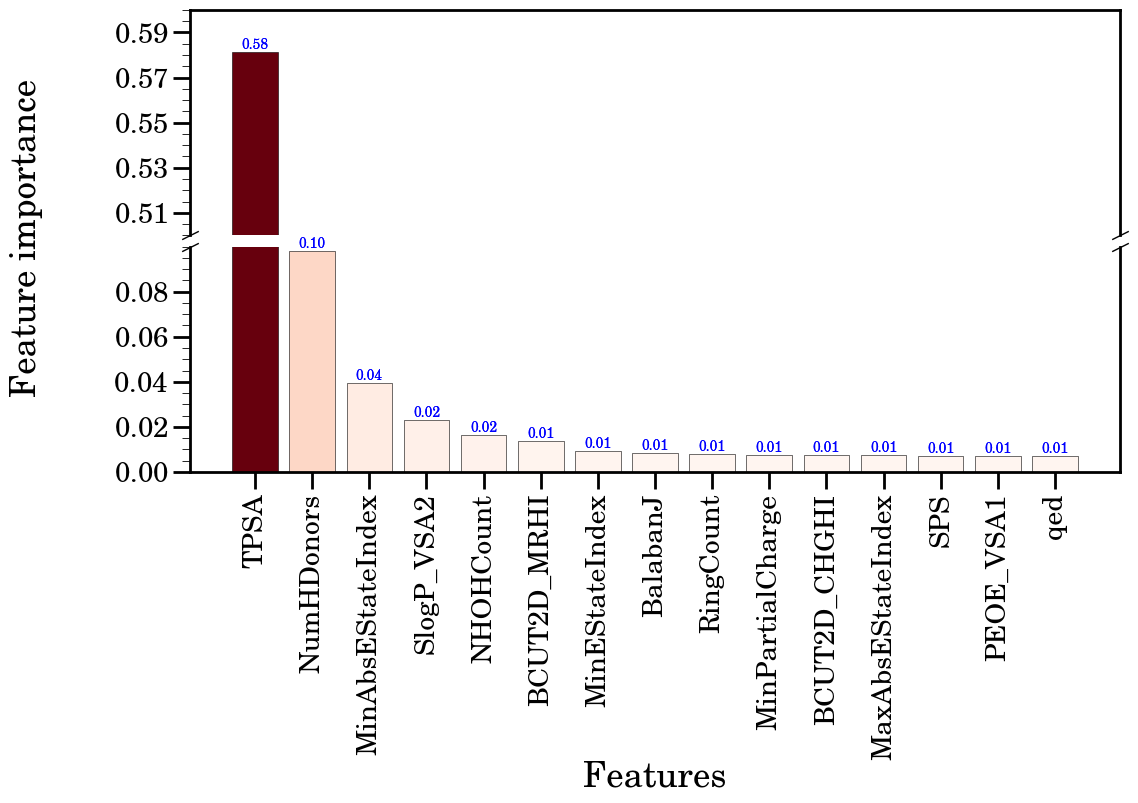

In [40]:
## Feature importance
all_df = df_with_200_descriptors[keys_95]
target = full['DeltaGsolv']

xgbr = RandomForestRegressor()
xgbr.fit(all_df.values, full['DeltaGsolv'].values)

# Assuming `xgbr` is the trained RandomForestRegressor model
importances = xgbr.feature_importances_
indices = np.argsort(importances)[::-1][:15]
features = np.array(list(keys_95))[indices][:15]
importances = importances[indices]

# Normalize the importances for color mapping
norm = plt.Normalize(importances.min(), importances.max())
colors = plt.cm.Reds(norm(importances))

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

# Plot the same data on both Axes
bars1 = ax1.bar(range(len(indices)), importances, color=colors, edgecolor='black')
bars2 = ax2.bar(range(len(indices)), importances, color=colors, edgecolor='black')

# Zoom-in / limit the view to different portions of the data
ax1.set_ylim(0.50, 0.6)  # outliers only
ax2.set_ylim(0, 0.1)  # most of the data

# Hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.set_xticks([])
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add numbers on top of the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    if height > 0.1:
        ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='blue')
    else:
        ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='blue')

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Add labels and title
ax2.set_xlabel('Features', fontsize = 25)
ax1.set_ylabel('')
ax2.set_ylabel('')
#ax1.set_title('Feature Importance with Gradient Color')
ax2.set_xticks(range(len(importances)))
ax2.set_xticklabels(features, rotation=90)

ax2.set_yticks([0.0, 0.02, 0.04, 0.06, 0.08])
ax1.set_yticks([0.51, 0.53, 0.55, 0.57,0.59])
ax1.xaxis.set_tick_params(which="both", size = 0)
ax2.xaxis.set_tick_params(which="minor", size = 0)
fig.text(s = "Feature importance", x = -0.025, y = 0.5, rotation = 90, va = "center", fontsize = 25)
#fig.tight_layout()
#plt.savefig("Feature_importance_rfr.png")
plt.show()

/tmp/ipykernel_2718827/4028908281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df[r'$\rm \Delta G_{solv}$'] = target


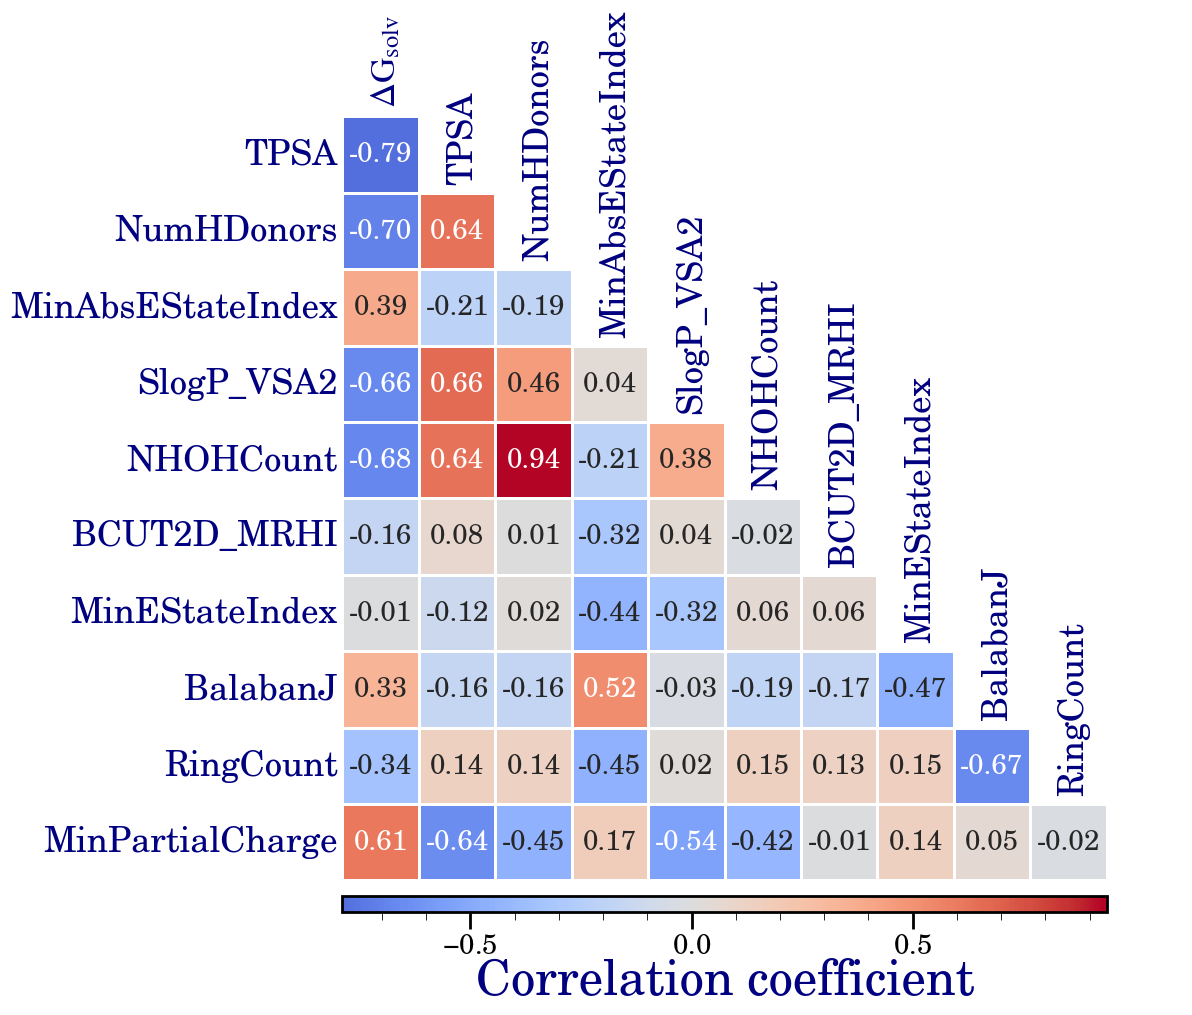

In [45]:
corr_df = all_df[features[:10]]
corr_df[r'$\rm \Delta G_{solv}$'] = target
cols = [r'$\rm \Delta G_{solv}$'] + [col for col in corr_df if col != r'$\rm \Delta G_{solv}$']
corr_df = corr_df[cols]


fig, ax = plt.subplots(figsize=(12, 12))

mask = np.zeros_like(corr_df.corr(numeric_only=True), dtype=bool)
mask[np.triu_indices_from(mask)] = True

heatmapkws = dict(square=True, cbar=False, cmap = "coolwarm", linewidths=1.0 )
im = sns.heatmap(corr_df.corr(numeric_only=True),  annot=True, fmt=".2f", annot_kws={"fontsize":20}, ax = ax, mask = mask,
                 center=0,
           xticklabels=False, yticklabels=True,cbar_kws={"shrink": .75, 'orientation': 'horizontal'} ,  **heatmapkws)
ax.yaxis.set_tick_params(which="both", size=0, width=0, direction='in', right=True, left=True)

ax.set_yticklabels([""] + cols[1:11], fontsize=25, color = "navy")
for i, label in enumerate(cols[0:10]):
    ax.text(x = i + 0.35, y = i +0.8, s = label, fontsize = 25, color = "navy", rotation = 90)
    #label.set_bbox(dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))
mappable = im.get_children()[0]
#plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.95, pad = 0.025)
cax = ax.inset_axes([0.0, -0.038, 0.91, 0.02])
cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal', label = "Correlation Coefficient",
             ticks = [-1, -0.5, 0, 0.5, 1])
cbar.set_label("Correlation coefficient", fontsize=35, color = "navy")
fig.tight_layout()
#plt.savefig("corr.png")
plt.show()

In [54]:
from regressor import Regressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge #type: ignore
from sklearn.svm import SVR #type: ignore

In [47]:
reg = Regressor()
rfr_model = reg.rfr(freesol_df75, freesoldf['DeltaGsolv'].values)
rfr = RandomForestRegressor(**rfr_model.best_params_)
scores_rfr_mnsol75 = cross_validate_model(mnsol_df75, mnsoldf['DeltaGsolv'].values , rfr)
rfr = RandomForestRegressor(**rfr_model.best_params_)
scores_rfr_fsol75 = cross_validate_model(freesol_df75, freesoldf['DeltaGsolv'].values , rfr)
rfr = RandomForestRegressor(**rfr_model.best_params_)
scores_rfr_csol75 = cross_validate_model(combisol_df75, combisolv['DeltaGsolv'].values , rfr)

In [48]:
reg = Regressor()
xgbr_model = reg.xgbr(freesol_df75, freesoldf['DeltaGsolv'].values)
xgbr = XGBRegressor(**xgbr_model.best_params_)
scores_xgbr_mnsol75 = cross_validate_model(mnsol_df75, mnsoldf['DeltaGsolv'].values , xgbr)
xgbr = XGBRegressor(**xgbr_model.best_params_)
scores_xgbr_fsol75 = cross_validate_model(freesol_df75, freesoldf['DeltaGsolv'].values , xgbr)
xgbr = XGBRegressor(**xgbr_model.best_params_)
scores_xgbr_csol75 = cross_validate_model(combisol_df75, combisolv['DeltaGsolv'].values , xgbr)

In [50]:
scaler = MinMaxScaler()
freesol_df75_ = scaler.fit_transform(freesol_df75)
scaler = MinMaxScaler()
mnsol_df75_ = scaler.fit_transform(mnsol_df75)
scaler = MinMaxScaler()
combisol_df75_ = scaler.fit_transform(combisol_df75)


In [53]:
reg = Regressor()
krr_model = reg.krr(freesol_df75_, freesoldf['DeltaGsolv'].values)
krr = KernelRidge(**krr_model.best_params_)
scores_krr_mnsol75 = cross_validate_model(mnsol_df75_, mnsoldf['DeltaGsolv'].values , krr)
krr = KernelRidge(**krr_model.best_params_)
scores_krr_fsol75 = cross_validate_model(freesol_df75_, freesoldf['DeltaGsolv'].values , krr)
krr = KernelRidge(**krr_model.best_params_)
scores_krr_csol75 = cross_validate_model(combisol_df75_, combisolv['DeltaGsolv'].values , krr)

In [55]:
reg = Regressor()
svr_model = reg.svr(freesol_df75_, freesoldf['DeltaGsolv'].values)
svr = SVR(**svr_model.best_params_)
scores_svr_mnsol75 = cross_validate_model(mnsol_df75_, mnsoldf['DeltaGsolv'].values , svr)
svr = SVR(**svr_model.best_params_)
scores_svr_fsol75 = cross_validate_model(freesol_df75_, freesoldf['DeltaGsolv'].values , svr)
svr = SVR(**svr_model.best_params_)
scores_svr_csol75 = cross_validate_model(combisol_df75_, combisolv['DeltaGsolv'].values , svr)

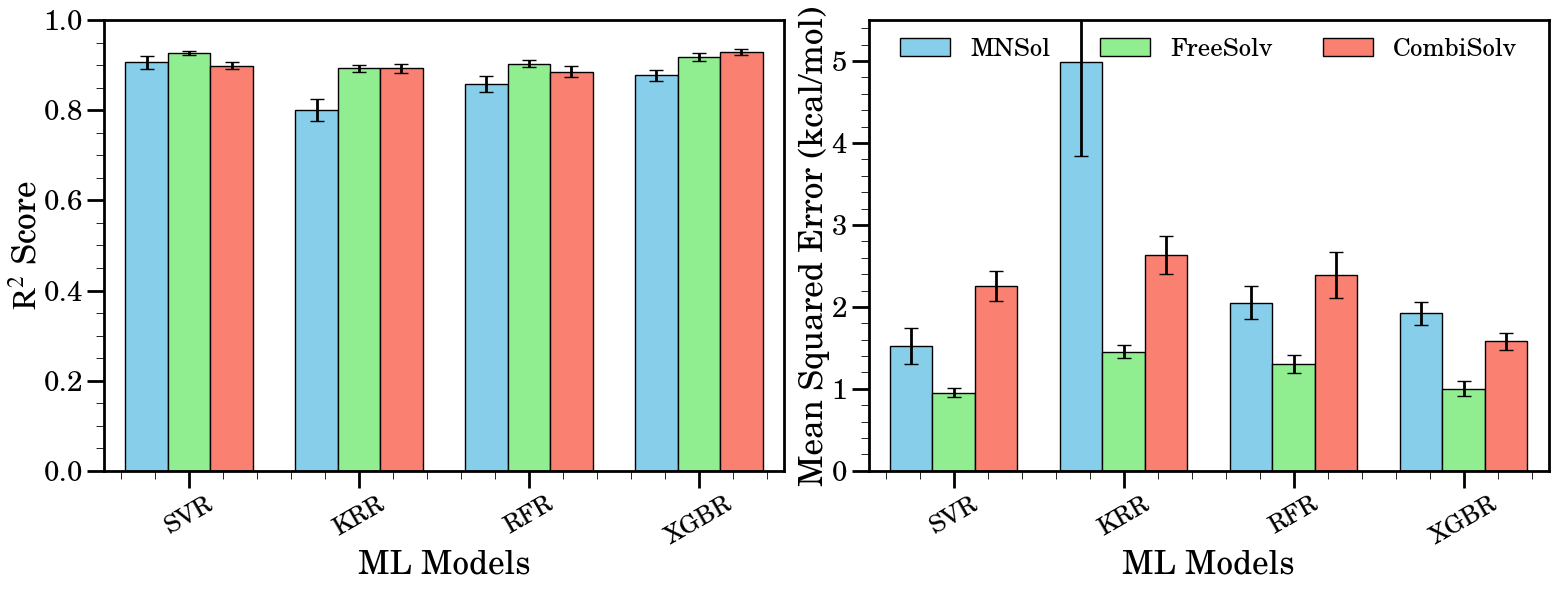

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# Data for the plot
representations = ['SVR', 'KRR', 'RFR', 'XGBR']
mnsol_means = [
    np.mean(scores_svr_mnsol75[:, 0]),
    np.mean(scores_krr_mnsol75[:, 0]),
    np.mean(scores_rfr_mnsol75[:, 0]),
    np.mean(scores_xgbr_mnsol75[:, 0]),
]
fsol_means = [
    np.mean(scores_svr_fsol75[:, 0]),
    np.mean(scores_krr_fsol75[:, 0]),
    np.mean(scores_rfr_fsol75[:, 0]),
    np.mean(scores_xgbr_fsol75[:, 0]),

]
csol_means = [
    np.mean(scores_svr_csol75[:, 0]),
    np.mean(scores_krr_csol75[:, 0]),
    np.mean(scores_rfr_csol75[:, 0]),
    np.mean(scores_xgbr_csol75[:, 0]),

]
mnsol_stds = [
    np.std(scores_svr_mnsol75[:, 0]),
    np.std(scores_krr_mnsol75[:, 0]),
    np.std(scores_rfr_mnsol75[:, 0]),
    np.std(scores_xgbr_mnsol75[:, 0]),
]
fsol_stds = [
    np.std(scores_svr_fsol75[:, 0]),
    np.std(scores_krr_fsol75[:, 0]),
    np.std(scores_rfr_fsol75[:, 0]),
    np.std(scores_xgbr_fsol75[:, 0]),
]
csol_stds = [
    np.std(scores_svr_csol75[:, 0]),
    np.std(scores_krr_csol75[:, 0]),
    np.std(scores_rfr_csol75[:, 0]),
    np.std(scores_xgbr_csol75[:, 0]),
]
mnsol_stds = np.array(mnsol_stds) / np.sqrt(10)
fsol_stds = np.array(fsol_stds) / np.sqrt(10)
csol_stds = np.array(csol_stds) / np.sqrt(10)

bar_width = 0.25
x = np.arange(len(representations))

bars1 = ax[0].bar(x - bar_width, mnsol_means, bar_width, yerr=mnsol_stds, capsize=5, label='MNSol', color='skyblue', edgecolor='black', lw = 1.)
bars2 = ax[0].bar(x, fsol_means, bar_width, yerr=fsol_stds, capsize=5, label='FreeSolv', color='lightgreen', edgecolor='black', lw = 1)
bars3 = ax[0].bar(x + bar_width, csol_means, bar_width, yerr=csol_stds, capsize=5, label='CombiSolv', color='salmon', edgecolor='black', lw = 1)

# Add labels and title
ax[0].set_xlabel('ML Models', fontsize=24)
ax[0].set_ylabel(r'$\rm R^2$ Score', fontsize=24)
ax[0].set_xticks(x)
ax[0].set_xlim(-0.5, 5.5)
ax[0].set_xticklabels(representations, rotation=30, ha='center', fontsize=18)
#ax[0].legend(ncols = 3, fontsize = 18, loc = "upper center")

# Data for the plot
mnsol_means = [
    np.mean(scores_svr_mnsol75[:, 1]),
    np.mean(scores_krr_mnsol75[:, 1]),
    np.mean(scores_rfr_mnsol75[:, 1]),
    np.mean(scores_xgbr_mnsol75[:, 1]),
]
fsol_means = [
    np.mean(scores_svr_fsol75[:, 1]),
    np.mean(scores_krr_fsol75[:, 1]),
    np.mean(scores_rfr_fsol75[:, 1]),
    np.mean(scores_xgbr_fsol75[:, 1]),

]
csol_means = [
    np.mean(scores_svr_csol75[:, 1]),
    np.mean(scores_krr_csol75[:, 1]),
    np.mean(scores_rfr_csol75[:, 1]),
    np.mean(scores_xgbr_csol75[:, 1]),

]
mnsol_stds = [
    np.std(scores_svr_mnsol75[:, 1]),
    np.std(scores_krr_mnsol75[:, 1]),
    np.std(scores_rfr_mnsol75[:, 1]),
    np.std(scores_xgbr_mnsol75[:, 1]),
]
fsol_stds = [
    np.std(scores_svr_fsol75[:, 1]),
    np.std(scores_krr_fsol75[:, 1]),
    np.std(scores_rfr_fsol75[:, 1]),
    np.std(scores_xgbr_fsol75[:, 1]),
]
csol_stds = [
    np.std(scores_svr_csol75[:, 1]),
    np.std(scores_krr_csol75[:, 1]),
    np.std(scores_rfr_csol75[:, 1]),
    np.std(scores_xgbr_csol75[:, 1]),
]
mnsol_stds = np.array(mnsol_stds) / np.sqrt(10)
fsol_stds = np.array(fsol_stds) / np.sqrt(10)
csol_stds = np.array(csol_stds) / np.sqrt(10)

# Create the bar plot
bar_width = 0.25
x = np.arange(len(representations))

bars1 = ax[1].bar(x - bar_width, mnsol_means, bar_width, yerr=mnsol_stds, capsize=5, label='MNSol', color='skyblue', edgecolor='black', lw = 1.)
bars2 = ax[1].bar(x, fsol_means, bar_width, yerr=fsol_stds, capsize=5, label='FreeSolv', color='lightgreen', edgecolor='black', lw = 1)
bars3 = ax[1].bar(x + bar_width, csol_means, bar_width, yerr=csol_stds, capsize=5, label='CombiSolv', color='salmon', edgecolor='black', lw = 1)

# Add labels and title
ax[1].set_xlabel('ML Models', fontsize=24)
ax[1].set_ylabel(r'Mean Squared Error (kcal/mol)', fontsize=24)
#ax.set_title('Comparison of Different Representations (Mean R2 Score with Std Error)', fontsize=16)
ax[1].set_xticks(x)
ax[1].set_xlim(-0.5, 3.5)
ax[0].set_xlim(-0.5, 3.5)
ax[1].set_ylim(0, 5.5)
ax[1].set_xticklabels(representations, rotation=30, ha='center', fontsize=18)
ax[1].legend(ncols = 3, fontsize = 18, loc = "upper center")
fig.tight_layout()
#plt.savefig("Comparison_of_models_desc.png")

In [ ]:
xgbr = XGBRegressor(**xgbr_model.best_params_)

xgbr.fit(mnsol_df75.values, mnsoldf['DeltaGsolv'].values)

# Test the trained model on FreeSolv dataset

y_pred_mnsol_mn = xgbr.predict(mnsol_df75.values)
y_pred_fsol_mn = xgbr.predict(freesol_df75.values)
y_pred_csol_mn = xgbr.predict(combisol_df75.values)

# Calculate metrics
r2_fsol_mn = r2_score(freesoldf['DeltaGsolv'].values, y_pred_fsol_mn)
mse_fsol_mn = mean_squared_error(freesoldf['DeltaGsolv'].values, y_pred_fsol_mn)

# Calculate metrics
r2_csol_mn = r2_score(combisolv['DeltaGsolv'].values, y_pred_csol_mn)
mse_csol_mn = mean_squared_error(combisolv['DeltaGsolv'].values, y_pred_csol_mn)

In [71]:
xgbr = XGBRegressor(**xgbr_model.best_params_)

xgbr.fit(freesol_df75.values, freesoldf['DeltaGsolv'].values)

# Test the trained model on FreeSolv dataset
y_pred_mnsol_f = xgbr.predict(mnsol_df75.values)
y_pred_fsol_f = xgbr.predict(freesol_df75.values)
y_pred_csol_f = xgbr.predict(combisol_df75.values)

# Calculate metrics
r2_mnsol_f = r2_score(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_f)
mse_mnsol_f = mean_squared_error(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_f)

# Calculate metrics
r2_csol_f = r2_score(combisolv['DeltaGsolv'].values, y_pred_csol_f)
mse_csol_f = mean_squared_error(combisolv['DeltaGsolv'].values, y_pred_csol_f)

In [72]:
xgbr = XGBRegressor(**xgbr_model.best_params_)

xgbr.fit(combisol_df75.values, combisolv['DeltaGsolv'].values)

# Test the trained model on FreeSolv dataset
y_pred_mnsol_c = xgbr.predict(mnsol_df75.values)
y_pred_fsol_c = xgbr.predict(freesol_df75.values)
y_pred_csol_c = xgbr.predict(combisol_df75.values)

# Calculate metrics
r2_mnsol_c = r2_score(mnsoldf['DeltaGsolv'].values, y_pred_mnol_c)
mse_mnsol_c = mean_squared_error(mnsoldf['DeltaGsolv'].values, y_pred_mnol_c)

# Calculate metrics
r2_fsol_c = r2_score(freesoldf['DeltaGsolv'].values, y_pred_fsol_c)
mse_fsol_c = mean_squared_error(freesoldf['DeltaGsolv'].values, y_pred_fsol_c)

# Calculate metrics
r2_csol_c = r2_score(combisolv['DeltaGsolv'].values, y_pred_csol_c)
mse_csol_c = mean_squared_error(combisolv['DeltaGsolv'].values, y_pred_csol_c)

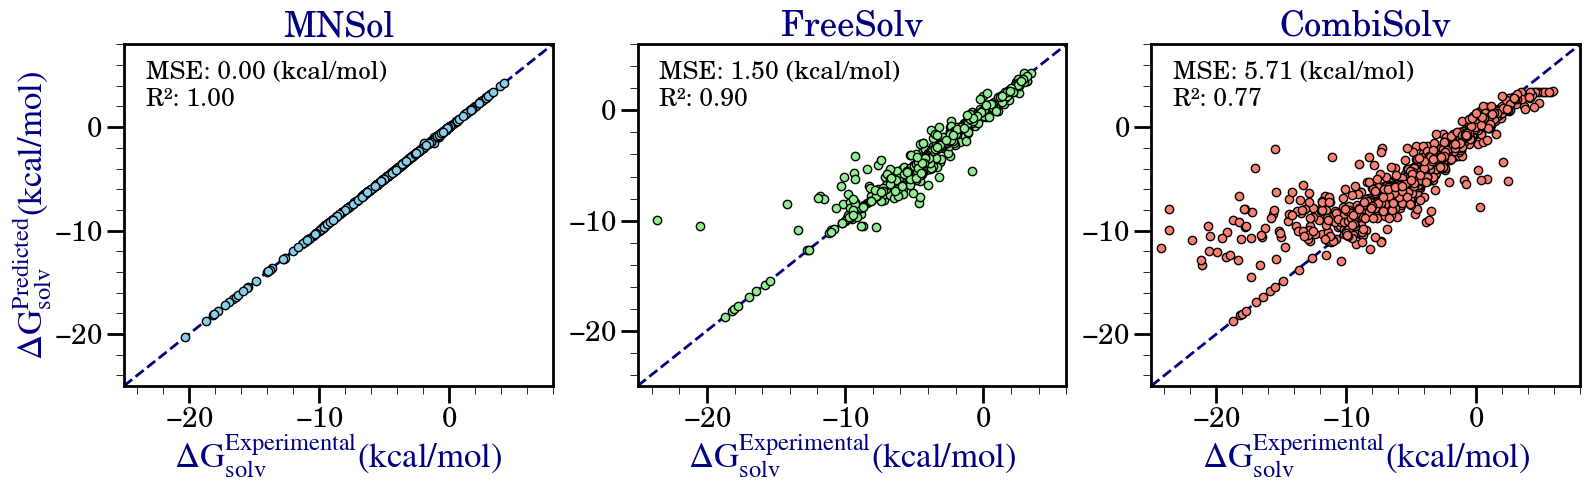

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax[0].plot([-25, 8], [-25, 8], ls = "--", color = 'navy')
ax[1].plot([-25, 8], [-25, 8], ls = "--", color = 'navy')
ax[2].plot([-25, 8], [-25, 8], ls = "--", color = 'navy')

ax[0].plot(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_mn, "o", color = "skyblue")
ax[1].plot(freesoldf['DeltaGsolv'].values, y_pred_fsol_mn, "o", color='lightgreen')
ax[2].plot(combisolv['DeltaGsolv'].values, y_pred_csol_mn, "o", color='salmon')

ax[0].set_xlim(-25, 8)
ax[0].set_ylim(-25, 8)

ax[1].set_xlim(-25, 6)
ax[1].set_ylim(-25, 6)

ax[2].set_xlim(-25, 8)
ax[2].set_ylim(-25, 8)

ax[0].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color = 'navy')
ax[1].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color = 'navy')
ax[2].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color = 'navy')
ax[0].set_ylabel(r"$\rm \Delta G^{Predicted}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color = 'navy')

# Add MSE and R² values as text
mse_mn = mean_squared_error(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_mn,)
r2_mn = r2_score(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_mn,)

mse_f = mean_squared_error(freesoldf['DeltaGsolv'].values, y_pred_fsol_mn,)
r2_f = r2_score(freesoldf['DeltaGsolv'].values, y_pred_fsol_mn,)

mse_c = mean_squared_error(combisolv['DeltaGsolv'].values, y_pred_csol_mn,)
r2_c = r2_score(combisolv['DeltaGsolv'].values, y_pred_csol_mn,)

ax[0].text(0.05, 0.95, f'MSE: {mse_mn:.2f} (kcal/mol)\nR²: {r2_mn:.2f}', transform=ax[0].transAxes, fontsize=18, verticalalignment='top')
ax[1].text(0.05, 0.95, f'MSE: {mse_f:.2f} (kcal/mol)\nR²: {r2_f:.2f}', transform=ax[1].transAxes, fontsize=18, verticalalignment='top')
ax[2].text(0.05, 0.95, f'MSE: {mse_c:.2f} (kcal/mol)\nR²: {r2_c:.2f}', transform=ax[2].transAxes, fontsize=18, verticalalignment='top')
ax[0].set_title("MNSol", loc = "center", fontsize = 25, color = "navy")
ax[1].set_title("FreeSolv", loc = "center", fontsize = 25, color = "navy")
ax[2].set_title("CombiSolv", loc = "center", fontsize = 25, color = "navy")

fig.tight_layout()
#plt.savefig("transferability_desc.png")

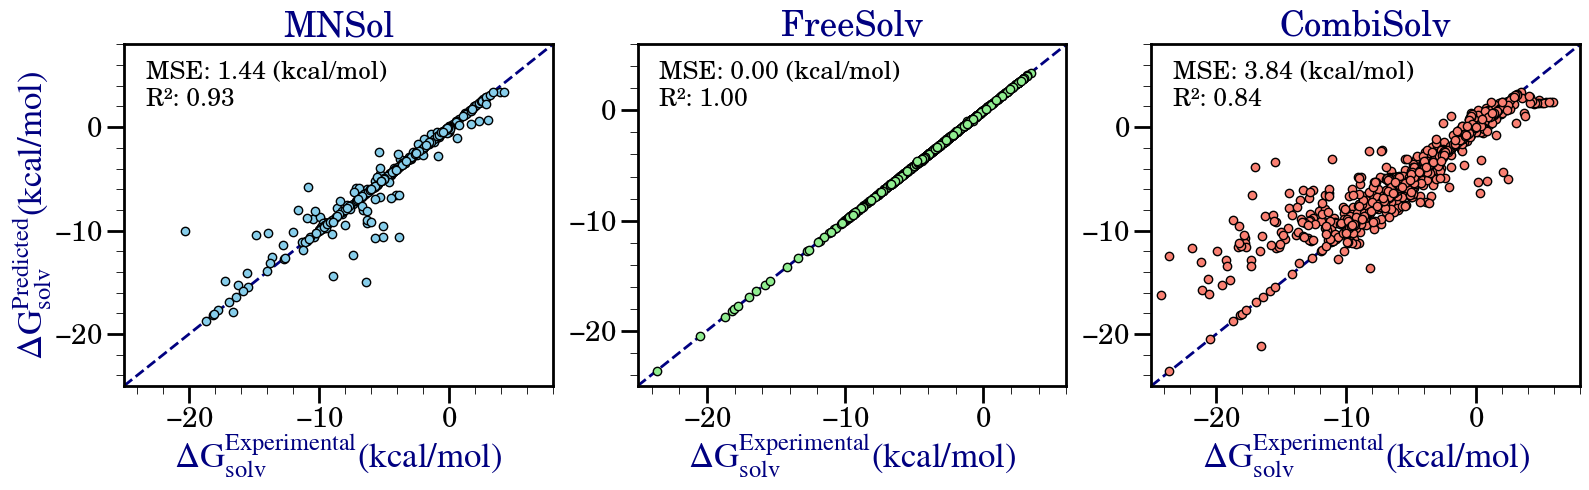

In [93]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax[0].plot([-25, 8], [-25, 8], ls = "--", color = 'navy')
ax[1].plot([-25, 8], [-25, 8], ls = "--", color = 'navy')
ax[2].plot([-25, 8], [-25, 8], ls = "--", color = 'navy')

ax[0].plot(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_f, "o", color = "skyblue")
ax[1].plot(freesoldf['DeltaGsolv'].values, y_pred_fsol_f, "o", color='lightgreen')
ax[2].plot(combisolv['DeltaGsolv'].values, y_pred_csol_f, "o", color='salmon')

ax[0].set_xlim(-25, 8)
ax[0].set_ylim(-25, 8)

ax[1].set_xlim(-25, 6)
ax[1].set_ylim(-25, 6)

ax[2].set_xlim(-25, 8)
ax[2].set_ylim(-25, 8)

ax[0].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color = 'navy')
ax[1].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color = 'navy')
ax[2].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color = 'navy')
ax[0].set_ylabel(r"$\rm \Delta G^{Predicted}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color = 'navy')

# Add MSE and R² values as text
mse_mn = mean_squared_error(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_f,)
r2_mn = r2_score(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_f,)

mse_f = mean_squared_error(freesoldf['DeltaGsolv'].values, y_pred_fsol_f,)
r2_f = r2_score(freesoldf['DeltaGsolv'].values, y_pred_fsol_f,)

mse_c = mean_squared_error(combisolv['DeltaGsolv'].values, y_pred_csol_f,)
r2_c = r2_score(combisolv['DeltaGsolv'].values, y_pred_csol_f,)

ax[0].text(0.05, 0.95, f'MSE: {mse_mn:.2f} (kcal/mol)\nR²: {r2_mn:.2f}', transform=ax[0].transAxes, fontsize=18, verticalalignment='top')
ax[1].text(0.05, 0.95, f'MSE: {mse_f:.2f} (kcal/mol)\nR²: {r2_f:.2f}', transform=ax[1].transAxes, fontsize=18, verticalalignment='top')
ax[2].text(0.05, 0.95, f'MSE: {mse_c:.2f} (kcal/mol)\nR²: {r2_c:.2f}', transform=ax[2].transAxes, fontsize=18, verticalalignment='top')
ax[0].set_title("MNSol", loc = "center", fontsize = 25, color = "navy")
ax[1].set_title("FreeSolv", loc = "center", fontsize = 25, color = "navy")
ax[2].set_title("CombiSolv", loc = "center", fontsize = 25, color = "navy")

fig.tight_layout()
#plt.savefig("transferability_desc.png")

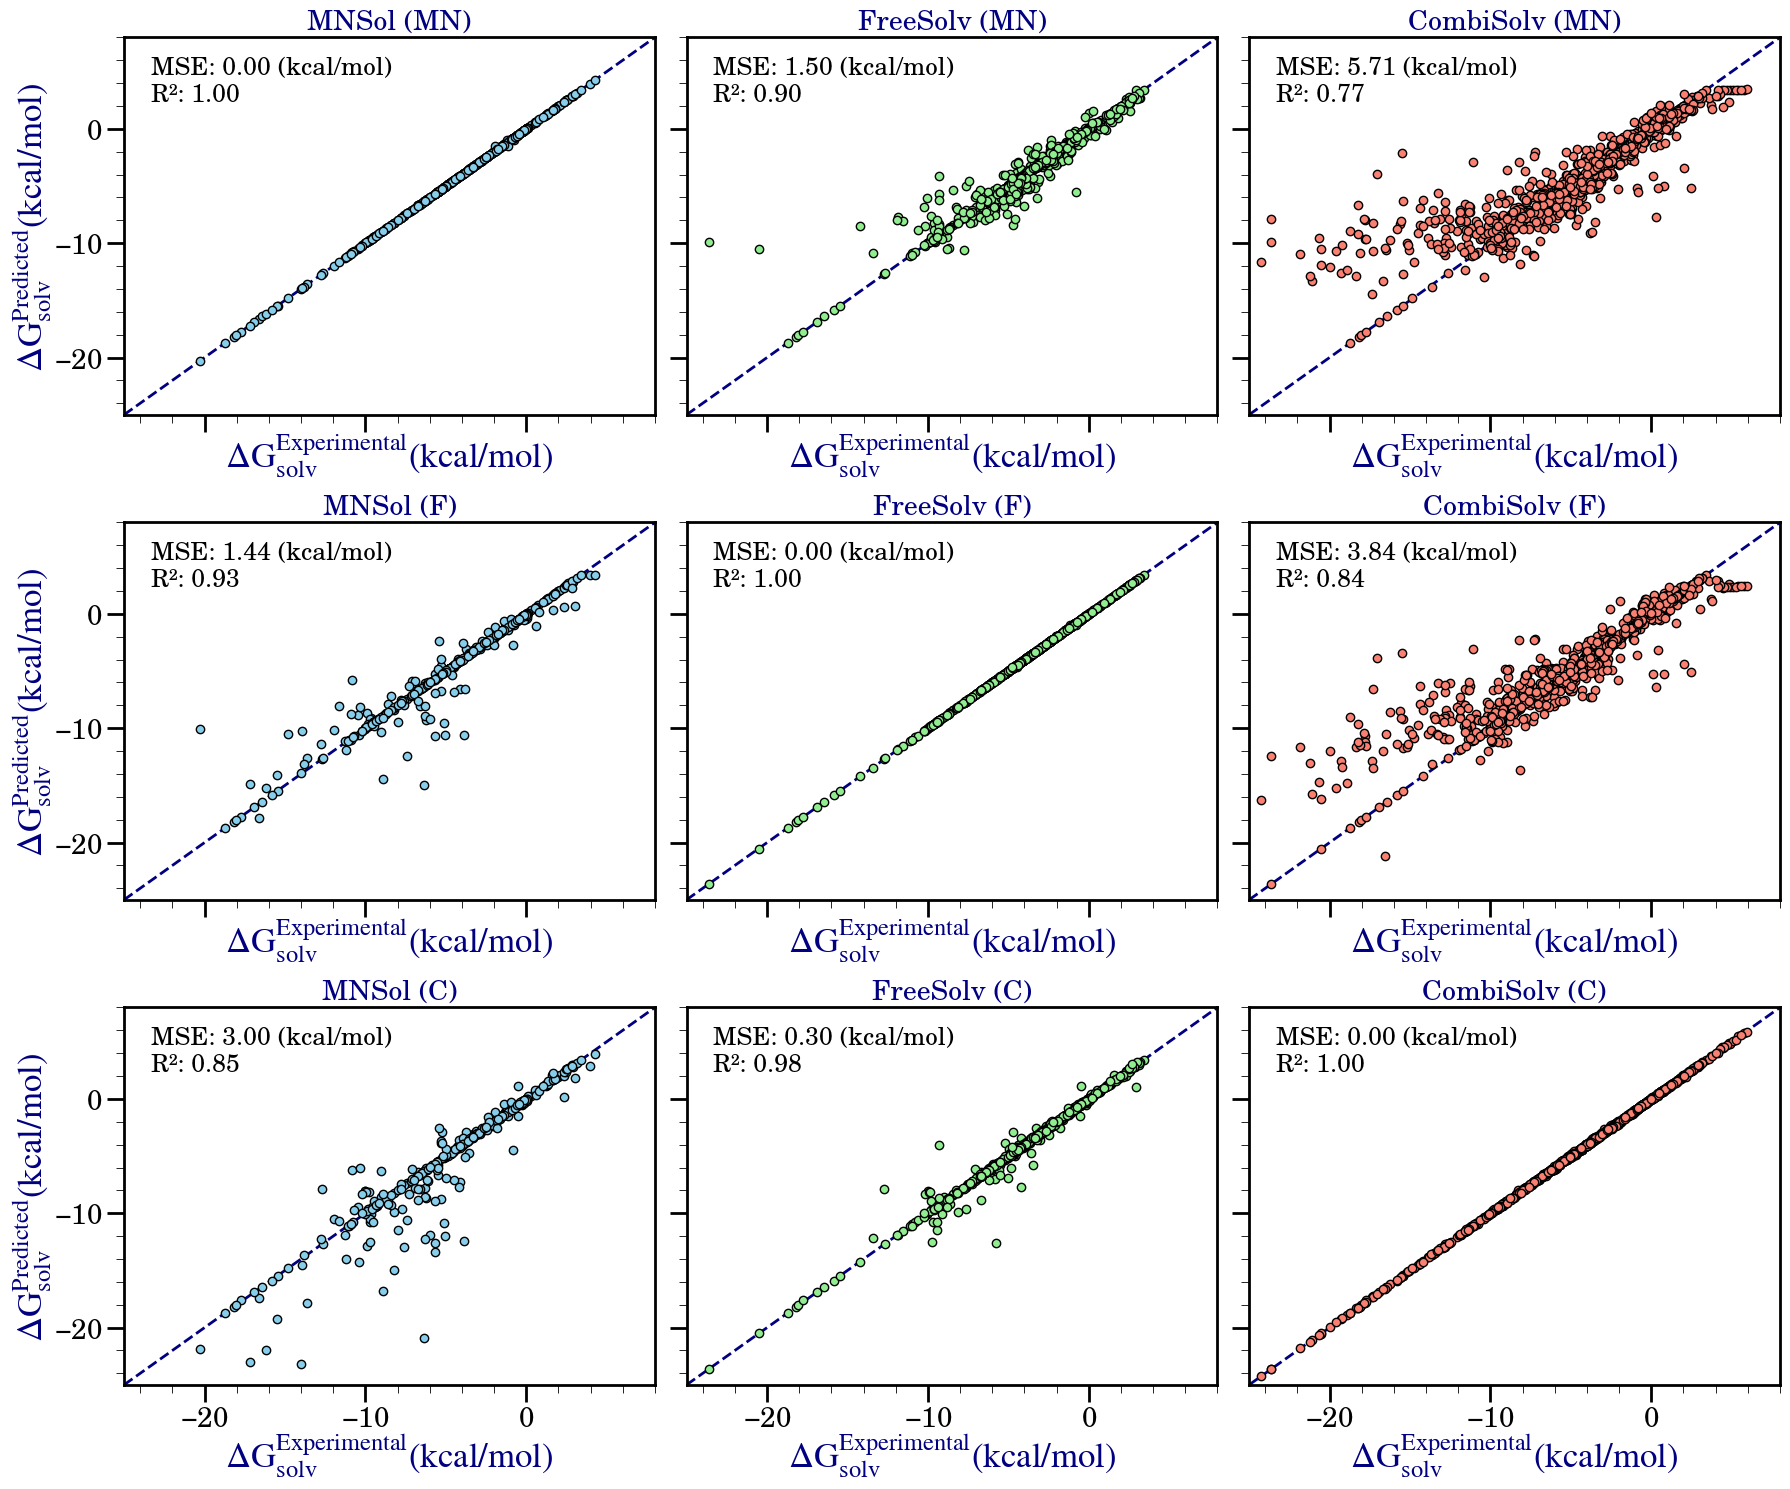

In [97]:
fig, ax = plt.subplots(3, 3, figsize=(18, 15), sharex=True, sharey=True)

# First row
ax[0, 0].plot([-25, 8], [-25, 8], ls="--", color="navy")
ax[0, 0].plot(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_mn, "o", color="skyblue")
ax[0, 0].set_xlim(-25, 8)
ax[0, 0].set_ylim(-25, 8)
ax[0, 0].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[0, 0].set_ylabel(r"$\rm \Delta G^{Predicted}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[0, 0].set_title("MNSol (MN)", fontsize=20, color="navy", loc = "center")

ax[0, 1].plot([-25, 8], [-25, 8], ls="--", color="navy")
ax[0, 1].plot(freesoldf['DeltaGsolv'].values, y_pred_fsol_mn, "o", color="lightgreen")
ax[0, 1].set_xlim(-25, 6)
ax[0, 1].set_ylim(-25, 6)
ax[0, 1].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[0, 1].set_title("FreeSolv (MN)", fontsize=20, color="navy", loc = "center")

ax[0, 2].plot([-25, 8], [-25, 8], ls="--", color="navy")
ax[0, 2].plot(combisolv['DeltaGsolv'].values, y_pred_csol_mn, "o", color="salmon")
ax[0, 2].set_xlim(-25, 8)
ax[0, 2].set_ylim(-25, 8)
ax[0, 2].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[0, 2].set_title("CombiSolv (MN)", fontsize=20, color="navy", loc = "center")


# Add MSE and R² values as text
mse_mn = mean_squared_error(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_mn,)
r2_mn = r2_score(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_mn,)

mse_f = mean_squared_error(freesoldf['DeltaGsolv'].values, y_pred_fsol_mn,)
r2_f = r2_score(freesoldf['DeltaGsolv'].values, y_pred_fsol_mn,)

mse_c = mean_squared_error(combisolv['DeltaGsolv'].values, y_pred_csol_mn,)
r2_c = r2_score(combisolv['DeltaGsolv'].values, y_pred_csol_mn,)

ax[0, 0].text(0.05, 0.95, f'MSE: {mse_mn:.2f} (kcal/mol)\nR²: {r2_mn:.2f}', transform=ax[0, 0].transAxes, fontsize=18, verticalalignment='top')
ax[0, 1].text(0.05, 0.95, f'MSE: {mse_f:.2f} (kcal/mol)\nR²: {r2_f:.2f}', transform=ax[0, 1].transAxes, fontsize=18, verticalalignment='top')
ax[0, 2].text(0.05, 0.95, f'MSE: {mse_c:.2f} (kcal/mol)\nR²: {r2_c:.2f}', transform=ax[0, 2].transAxes, fontsize=18, verticalalignment='top')


# Second row
ax[1, 0].plot([-25, 8], [-25, 8], ls="--", color="navy")
ax[1, 0].plot(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_f, "o", color="skyblue")
ax[1, 0].set_xlim(-25, 8)
ax[1, 0].set_ylim(-25, 8)
ax[1, 0].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[1, 0].set_ylabel(r"$\rm \Delta G^{Predicted}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[1, 0].set_title("MNSol (F)", fontsize=20, color="navy", loc = "center")

ax[1, 1].plot([-25, 8], [-25, 8], ls="--", color="navy")
ax[1, 1].plot(freesoldf['DeltaGsolv'].values, y_pred_fsol_f, "o", color="lightgreen")
ax[1, 1].set_xlim(-25, 6)
ax[1, 1].set_ylim(-25, 6)
ax[1, 1].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[1, 1].set_title("FreeSolv (F)", fontsize=20, color="navy", loc = "center")

ax[1, 2].plot([-25, 8], [-25, 8], ls="--", color="navy")
ax[1, 2].plot(combisolv['DeltaGsolv'].values, y_pred_csol_f, "o", color="salmon")
ax[1, 2].set_xlim(-25, 8)
ax[1, 2].set_ylim(-25, 8)
ax[1, 2].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[1, 2].set_title("CombiSolv (F)", fontsize=20, color="navy", loc = "center")

mse_mn = mean_squared_error(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_f,)
r2_mn = r2_score(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_f,)

mse_f = mean_squared_error(freesoldf['DeltaGsolv'].values, y_pred_fsol_f,)
r2_f = r2_score(freesoldf['DeltaGsolv'].values, y_pred_fsol_f,)

mse_c = mean_squared_error(combisolv['DeltaGsolv'].values, y_pred_csol_f,)
r2_c = r2_score(combisolv['DeltaGsolv'].values, y_pred_csol_f,)


ax[1, 0].text(0.05, 0.95, f'MSE: {mse_mn:.2f} (kcal/mol)\nR²: {r2_mn:.2f}', transform=ax[1, 0].transAxes, fontsize=18, verticalalignment='top')
ax[1, 1].text(0.05, 0.95, f'MSE: {mse_f:.2f} (kcal/mol)\nR²: {r2_f:.2f}', transform=ax[1, 1].transAxes, fontsize=18, verticalalignment='top')
ax[1, 2].text(0.05, 0.95, f'MSE: {mse_c:.2f} (kcal/mol)\nR²: {r2_c:.2f}', transform=ax[1, 2].transAxes, fontsize=18, verticalalignment='top')

# Third row
ax[2, 0].plot([-25, 8], [-25, 8], ls="--", color="navy")
ax[2, 0].plot(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_c, "o", color="skyblue")
ax[2, 0].set_xlim(-25, 8)
ax[2, 0].set_ylim(-25, 8)
ax[2, 0].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[2, 0].set_ylabel(r"$\rm \Delta G^{Predicted}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[2, 0].set_title("MNSol (C)", fontsize=20, color="navy", loc = "center")

ax[2, 1].plot([-25, 8], [-25, 8], ls="--", color="navy")
ax[2, 1].plot(freesoldf['DeltaGsolv'].values, y_pred_fsol_c, "o", color="lightgreen")
ax[2, 1].set_xlim(-25, 6)
ax[2, 1].set_ylim(-25, 6)
ax[2, 1].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[2, 1].set_title("FreeSolv (C)", fontsize=20, color="navy", loc = "center")

ax[2, 2].plot([-25, 8], [-25, 8], ls="--", color="navy")
ax[2, 2].plot(combisolv['DeltaGsolv'].values, y_pred_csol_c, "o", color="salmon")
ax[2, 2].set_xlim(-25, 8)
ax[2, 2].set_ylim(-25, 8)
ax[2, 2].set_xlabel(r"$\rm \Delta G^{Experimental}_{solv}(kcal/mol)$", fontdict={'fontsize': 25}, color='navy')
ax[2, 2].set_title("CombiSolv (C)", fontsize=20, color="navy", loc = "center")

# Add MSE and R² values as text
mse_mn = mean_squared_error(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_c,)
r2_mn = r2_score(mnsoldf['DeltaGsolv'].values, y_pred_mnsol_c,)

mse_f = mean_squared_error(freesoldf['DeltaGsolv'].values, y_pred_fsol_c,)
r2_f = r2_score(freesoldf['DeltaGsolv'].values, y_pred_fsol_c,)

mse_c = mean_squared_error(combisolv['DeltaGsolv'].values, y_pred_csol_c,)
r2_c = r2_score(combisolv['DeltaGsolv'].values, y_pred_csol_c,)

ax[2, 0].text(0.05, 0.95, f'MSE: {mse_mn:.2f} (kcal/mol)\nR²: {r2_mn:.2f}', transform=ax[2, 0].transAxes, fontsize=18, verticalalignment='top')
ax[2, 1].text(0.05, 0.95, f'MSE: {mse_f:.2f} (kcal/mol)\nR²: {r2_f:.2f}', transform=ax[2, 1].transAxes, fontsize=18, verticalalignment='top')
ax[2, 2].text(0.05, 0.95, f'MSE: {mse_c:.2f} (kcal/mol)\nR²: {r2_c:.2f}', transform=ax[2, 2].transAxes, fontsize=18, verticalalignment='top')

fig.tight_layout()
plt.savefig("transferability_desc_3x3.png")
plt.show()
